#Speech Processing Lab - Week 9

Name: S U Swakath 

Roll number: 180020036

Google Colab Link : https://colab.research.google.com/drive/1mnoWWqxvT7csVKhMgMOmuMJRI_um3D0S?usp=sharing

**Aim**
* To compute LP coefficients and LP residual of a given speech signal.
* To compute the formant parameters by LP analysis.
* To compute the excitation parameters like pitch by LP analysis.
* To compute the normalized error curves for voiced and unvoiced segments of speech.

**Theory**

Speech signal is produced by the convolution of excitation source and time varying vocal tract system components. These excitation and vocal tract components are to be separated from the available speech signal to study these components independently. For this purpose, methods based on homomorphic analysis like cepstral analysis are developed. As the cepstral analysis does the deconvolution of speech into source and system components by traversing through frequency domain, the deconvolution task becomes computational intensive process. To reduce such type of computational complexity and finding the source and system components from time domain itself, the Linear Prediction analysis is developed.

The prediction error in this method is given as:

$$e(n) = s(n) - \hat s(n)$$

$$e(n) = s(n) - \sum_{k=1}^{p} a_k s(n-k)$$

Differentiating and equating to zero, we obtain the **Yule-Walker** equation:

$$c(l, 0) = \sum_{k=1}^{p} a_k c(k, l)$$

We write it in the form,

$$\bar c = \textbf{C} \bar a$$

$$ \bar c =  \begin{bmatrix}
c(1,0)\\
c(2,0)\\
{...}\\
c(p,0)
\end{bmatrix} \quad
\textbf{C} = \begin{bmatrix}
c(1,1) & c(1,2) & {...} & c(1,p)\\
c(2,1) & c(2,2) & {...} & c(2,p)\\
{...} & {...} & {...} & {...}\\
c(p,1) & c(p,2) & {...} & c(p,p)
\end{bmatrix} \quad
\bar a =  \begin{bmatrix}
a_1\\
a_2\\
{...}\\
a_p
\end{bmatrix} \quad$$

We get the solution by inverting the covariance matrix,

$$\bar a = \textbf{C}^{-1} \bar c$$



# Problem A
Estimating Linear Prediction (LP) coefficients from the speech.
* Select a frame (25 ms long) at the center of a voiced segment. Estimate the LPCs of the segment using the autocorrelation method.


In [ ]:
# Mounting Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Changing directory
%cd /content/gdrive/MyDrive/Sem6/Speech Lab/Week9
!ls

/content/gdrive/MyDrive/Sem6/Speech Lab/Week9
Lab9.ipynb  week9audio.wav


In [ ]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import seaborn as sns

In [150]:
#Functions
# Magnitude spuctrum plot function
def magnitudeSpectrum(sound):
    
  # Computing the FFT of the sound
  sound_len = sound.shape[0]
  sound_fft = fft(sound)/sound_len

  # Computing the frequency array
  freqs = fftfreq(sound_len, 1/fs)
  
  freqs = freqs[0:sound_len//2]
  fft_db = np.log10(np.abs(sound_fft[0:sound_len//2]))
  #fft_db = np.log10(np.abs(sound_fft))
  return freqs,fft_db

def autocorr(sound):#, plot=0, sound_name=""):
    len = sound.shape[0]
    shift = np.arange(0, len, 1)
    autocorr = np.zeros((shift.shape[0],))

    for curr_shift in shift:
        autocorr[curr_shift] = np.dot(sound[0:len-curr_shift].T,sound[curr_shift:])

    return autocorr

# Function to estimate the LPCs using autocorrelation method
# Levinson-Durbin Recursion
def lpCoeff(sound,p):
    sound_acf = autocorr(sound)#, plot=0, sound_name=sound_name)
    energy = np.zeros((p+1, ))
    energy[0] = sound_acf[0]

    reflection_coeff = np.zeros((p+1, ))
    a = np.zeros((p+1, p+1))

    for i in range(1, p+1):

        reflection_coeff[i] = sound_acf[i] - np.dot(a[i-1][1:i], (sound_acf[1:i])[::-1])
        reflection_coeff = reflection_coeff / energy[i-1]

        for j in range(1, i):

            a[i][i] = reflection_coeff[i]
            a[i][j] = a[i-1][j] - reflection_coeff[i]*a[i-1][i-j]

        energy[i] = (1 - reflection_coeff[i]**2)*energy[i-1]

    return a[p][1:p+1]
def invMat(sound,p):
  acf = autocorr(sound)
  covMat = np.zeros([p,p])
  for i in range(p):
    for j in range(p):
      covMat[i,j] = acf[np.abs(i-j)]
  c = np.zeros([p,1])
  for i in range(p):
    c[i,0] = acf[i+1]
  #print(np.shape(covMat),np.shape(c))
  coeff = np.matmul(np.linalg.inv(covMat),c)
  coeff = coeff.T
  coeff = coeff.reshape(p)
  return coeff

# Function to plot the waveform
def wave_plot(sound, time, sound_name):
    plt.figure(figsize=(15,5))
    plt.plot(time, sound)
    plt.title("Time Domain Plot of sound "+ "/" + sound_name + "/")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

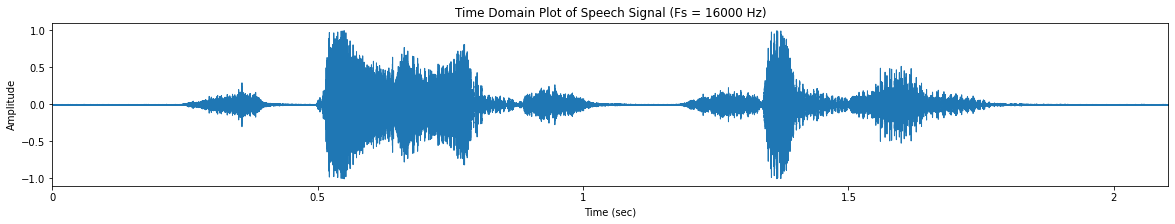

In [ ]:
# Loading the audio into colab. Fs = 16kHz
audio, fs = librosa.load("week9audio.wav", sr = 16000)

# Plotting time domain plot of the audio
plt.figure(figsize=(20,3))
librosa.display.waveplot(audio, sr=fs);
plt.title("Time Domain Plot of Speech Signal (Fs = " +str(fs)+" Hz)")
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Extracting different categories of sound in the speech
# The time stamp for each sound component was extracted from wavesurfer and they
# are as follows:

# /ee/ - 0.591 s to 0.756 s
ee = audio[int(0.591*fs):int(0.756*fs)] 

#Choosing one voiced sound (ee) and one unvoiced sound (s) and taking 20ms of the sound
frameSize = 0.020 * fs
midFrame = frameSize/2
N = len(ee) / 2
ee = ee[int (N-midFrame): int (N+midFrame)]

In [152]:
p = 12
Rec_ee = lpCoeff(ee, p)
lpCoeff_ee = invMat(ee,p)
print("Matrix Inversion p = 12:\n", lpCoeff_ee)
print("Recrusion p = 12:\n", Rec_ee)


Matrix Inversion p = 12:
 [ 1.29369465 -0.99400915  0.27400077  0.41938864  0.20535542 -0.27727877
  0.43326825 -0.00412717 -0.24303722 -0.26778596  0.24582197 -0.20845204]
Recrusion p = 12:
 [  0.66009098   6.85631005  -9.88446131  16.27925713   6.03976067
 -11.44365209   9.85921688  -2.36451186 -17.8392651    8.15214805
  -3.10261048  -2.41850975]


# Problem B

Computing LP residual
* Using the computed LPCs, derive the LP residual signal.

In [153]:
# using LPCs deriving the filter H
A = np.insert(-1*lpCoeff_ee, 0, 1)

H = fft(A, len(ee))
H = 1/H;
f_array = fftfreq(len(ee), 1/fs)

In [154]:
# DERIVING RESIDUAL SIGNAL

# We convolve the original signal with the A vector consisting of LPCs
residual = np.convolve(ee, A)
residual = residual[0:-len(A)+1]
t_res = np.arange(0, residual.shape[0]/fs, 1/fs)

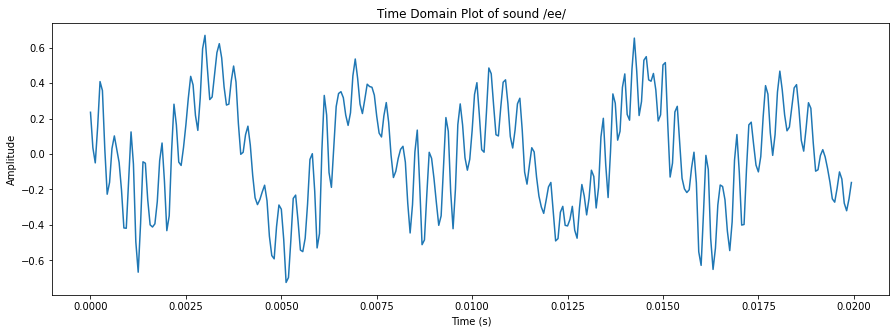

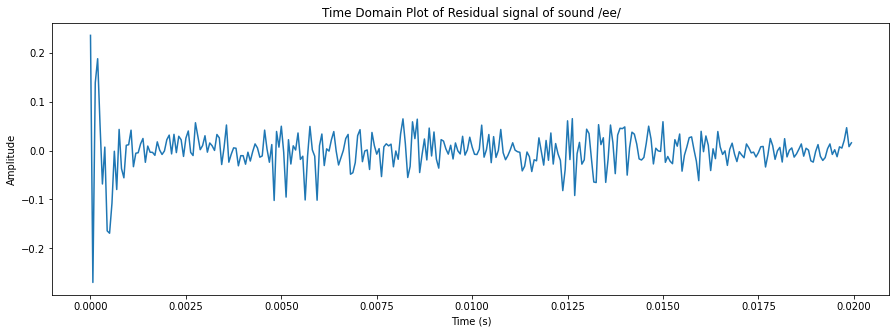

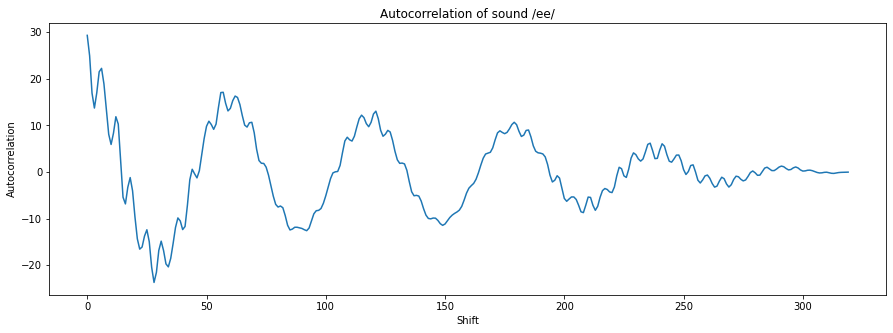

In [155]:
t_ee = np.arange(0, ee.shape[0]/fs, 1/fs)
wave_plot(ee, t_ee, "ee")

plt.figure(figsize=(15,5))
plt.plot(t_res, np.real(residual))
plt.title("Time Domain Plot of Residual signal of sound /ee/")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

curAuto = autocorr(ee)

plt.figure(figsize=(15,5))
plt.plot(curAuto)
plt.title("Autocorrelation of sound /ee/")
plt.xlabel('Shift')
plt.ylabel('Autocorrelation')
plt.show()

# Problem C

Pitch estimation from LP residual:
* Estimate the pitch from the estimated LP residual using autocorrelation.

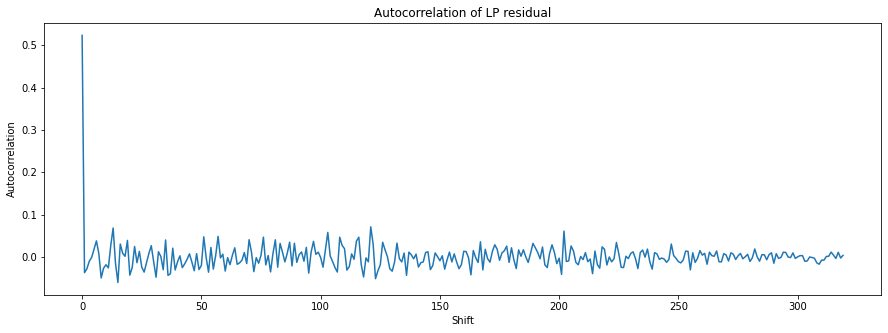

In [143]:
# performing the autocorrelation of LP residual
resAutocorr = autocorr(residual)
plt.figure(figsize=(15,5))
plt.plot(resAutocorr)
plt.title("Autocorrelation of LP residual")
plt.xlabel('Shift')
plt.ylabel('Autocorrelation')
plt.show()

In [156]:
offset = 30
truncated = resAutocorr[offset:-1]
index = np.argmax(truncated)

pitch = fs/(offset+index)
 
print("Estimated pitch =", pitch, "Hz")

Estimated pitch = 132.23140495867767 Hz


# Problem D
Formant estimation from LP spectrum:
* Explain, step by step, the procedure of computing the LP spectrum from LPCs.
* Demonstrate the same on the voiced frame selected above.

**Procedure**
1. We first calculate the LP coefficients using the autocorrelation method.
2. Then we obtain the frequency response of the filter using the LPCs.
3. We can plot this filter H to get the LP spectrum.

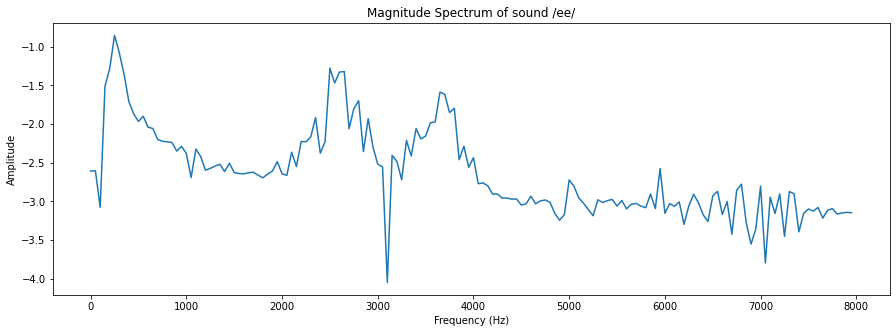

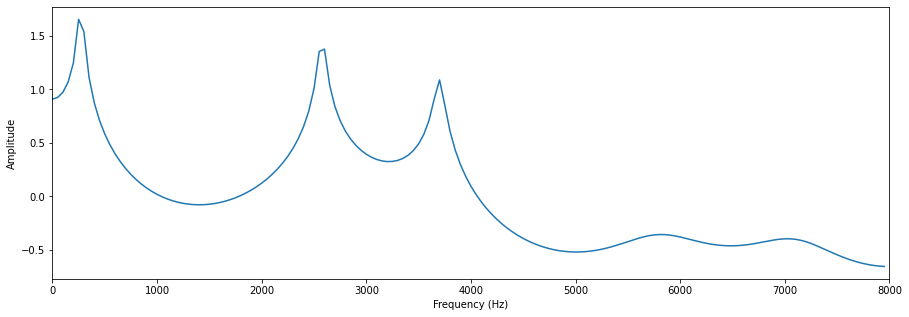

In [157]:
#plot_spectrum(ee, "ee", type='log')
freqs,freq_db = magnitudeSpectrum(ee)

plt.figure(figsize=(15,5))
plt.plot(freqs,freq_db)
plt.title("Magnitude Spectrum of sound /ee/")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(f_array[0:len(ee)//2], np.log10(np.abs((H[0:len(ee)//2]))))
#plt.title("Magnitude Spectrum of "+ "/" + sound_name + "/")
#plt.yscale('log')
plt.xlim((0, 8000))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Problem E
Normalized Error:

* Select the 25ms frame at the center of the voiced and unvoiced frame respectively. Compute the normalized LP residual error as a function of the order of LP prediction. Plot normalized error curve against the prediction order for both voiced and unvoiced frames
* Comment upon the choice of optimal prediction order for the  segments. 


In [146]:
#Choosing one unvoiced sound (s) and taking 20ms of the sound
frameSize = 0.020 * fs
midFrame = frameSize/2
N = len(ee) / 2
ss = audio[int(0.236*fs):int(0.387*fs)]
ss = s[int (N-midFrame): int (N+midFrame)]
t_ss = np.arange(0, s.shape[0]/fs, 1/fs)

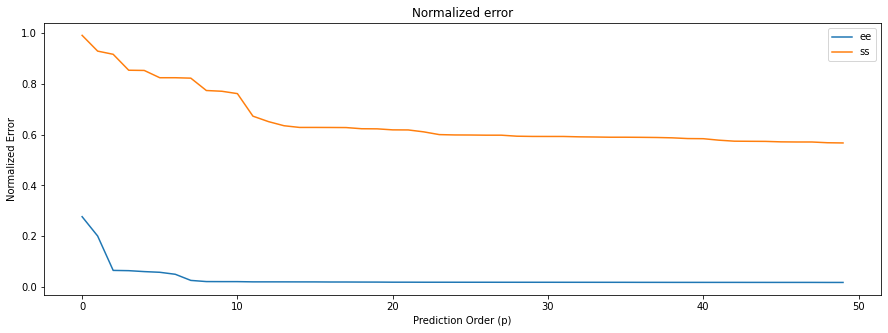

In [161]:
p_values = 50
error_ee = np.zeros((p_values,))
error_ss = np.zeros((p_values,))

for p in range(1, p_values+1):

    ee_acf = autocorr(ee)
    lp_coeff_ee = invMat(ee, p)

    temp_ee = np.dot(lp_coeff_ee, ee_acf[1:p+1])
    error_ee[p-1] = (ee_acf[0] - temp_ee)/ee_acf[0]

    ss_acf = autocorr(ss)
    lp_coeff_ss = invMat(ss, p)

    temp_ss = np.dot(lp_coeff_ss, ss_acf[1:p+1])
    error_ss[p-1] = (ss_acf[0] - temp_ss)/ss_acf[0]

plt.figure(figsize=(15,5))
plt.plot(error_ee)
plt.plot(error_ss)
plt.title("Normalized error")
plt.xlabel('Prediction Order (p)')
plt.ylabel('Normalized Error')
plt.legend(['ee','ss'])
plt.show()